In [123]:
import os
import pickle
from collections import defaultdict
import sklearn.cluster
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import itertools
import scipy.spatial
from pprint import pprint
import pandas as pd
import numpy as np
from batchers import batcher
import tensorflow as tf

In [124]:
# get locs from data/dhs_wealth_index.csv
surveys_df = pd.read_csv('../data/dhs_wealth_index.csv', float_precision='high')
surveys_df.rename({'LATNUM': 'lat', 'LONGNUM': 'lon', 'URBAN_RURA': 'urban'}, axis='columns', inplace=True)
for col in ['lat', 'lon', 'wealthpooled', 'wealth', 'wealthpooled5country']:
    surveys_df[col] = surveys_df[col].astype(np.float32)
surveys_df['country'] = (surveys_df['country']
                         .str.lower()
                         .str.replace(' ', '_')
                         .str.replace("'", '_'))
locs = np.transpose(np.array([surveys_df['lat'], surveys_df['lon']]))
locs = locs[~np.isnan(locs).any(1)]

#### loc_dict

In [125]:
def create_loc_dict(loc_dict_path):
    '''
    Args
    - loc_dict_path: str, path to save the loc_dict
    '''
    surveys_df = pd.read_csv('../data/dhs_wealth_index.csv', float_precision='high')
    surveys_df.rename({'LATNUM': 'lat', 'LONGNUM': 'lon', 'URBAN_RURA': 'urban'},
                      axis='columns', inplace=True)
    for col in ['lat', 'lon', 'wealthpooled', 'wealth', 'wealthpooled5country']:
        surveys_df[col] = surveys_df[col].astype(np.float32)
    surveys_df['country'] = (surveys_df['country']
                             .str.lower()
                             .str.replace(' ', '_')
                             .str.replace("'", '_'))

    loc_dict = {}

    for (lat, lon) in locs:
        loc = (lat, lon)
        row = surveys_df.loc[(surveys_df['lat'] == lat) & (surveys_df['lon'] == lon), :]
        #assert len(row) == 1
        row = row.iloc[0]

        cy = '{c}_{y}'.format(c=row['country'], y=row['svyid'][-4:])

        #assert loc not in loc_dict
        loc_dict[loc] = {
            'cluster': row['cluster'],
            'country': row['country'],
            'country_year': cy,  # surveyID
            'households': row['households'],
            'urban': row['urban'] == 'U',
            'wealth': row['wealth'],
            'wealthpooled': row['wealthpooled'],
            'year': row['year']
        }

    with open(loc_dict_path, 'wb') as f:
        pickle.dump(loc_dict, f)

In [126]:
loc_dict_path = '../data/dhs_loc_dict.pkl'

if not os.path.exists(loc_dict_path):
    create_loc_dict(loc_dict_path)

In [127]:
with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

In [128]:
# functions from sustainlab: data_analysis/create_folds.py
def create_folds(locs, min_dist, dist_metric, fold_names, verbose=True,
                 plot_largest_clusters=0):
    '''Partitions locs into folds.

    Args
    - locs: np.array, shape [N, 2]
    - min_dist: float, minimum distance between folds
    - dist_metric: str, a valid distance metric accepted by sklearn.cluster.dbscan
    - fold_names: list of str, names of folds
    - verbose: bool
    - plot_largest_clusters: int, number of largest clusters to plot

    Returns
    - locs_to_indices: dict, maps (lat, lon) tuple to index in locs np.array
    - folds: dict, fold name => np.array of indices of locs belonging to that fold
    '''
    # there are duplicate locs => we want to cluster based on unique locs
    locs_to_indices = defaultdict(list)
    for i, loc in enumerate(locs):
        locs_to_indices[tuple(loc)].append(i)

    unique_locs = np.unique(locs, axis=0)  # get unique rows

    # any point within `min_dist` of another point belongs to the same cluster
    # - cluster_labels assigns a cluster index (0-indexed) to each loc
    # - a cluster label of -1 means that the point is an outlier
    _, cluster_labels = sklearn.cluster.dbscan(
        X=unique_locs, eps=min_dist, min_samples=2, metric=dist_metric)

    if verbose:
        _, unique_counts = np.unique(cluster_labels, return_counts=True)

        print('num clusters:', np.max(cluster_labels) + 1)  # clusters are 0-indexed
        print('max cluster size:', np.max(unique_counts[1:]))  # exclude outliers
        print('num outliers:', np.sum(cluster_labels == -1))

        fig, ax = plt.subplots(1, 1, figsize=[4, 2.5], constrained_layout=True)
        ax.hist(unique_counts[1:], bins=50)  # exclude outliers
        ax.set(xlabel='cluster size', ylabel='count')
        ax.set_yscale('log')
        ax.set_title('histogram of cluster sizes (excluding outliers)')
        ax.grid(True)
        plt.show()

    # mapping: cluster number => list of indices of points in that cluster
    # - if cluster label is -1 (outlier), then treat that unique loc as its own cluster
    neg_counter = -1
    clusters_dict = defaultdict(list)
    for loc, c in zip(unique_locs, cluster_labels):
        indices = locs_to_indices[tuple(loc)]
        if c < 0:
            c = neg_counter
            neg_counter -= 1
        clusters_dict[c].extend(indices)

    # sort clusters by descending cluster size
    sorted_clusters = sorted(clusters_dict.keys(), key=lambda c: -len(clusters_dict[c]))

    # plot the largest clusters
    for i in range(plot_largest_clusters):
        c = sorted_clusters[i]
        indices = clusters_dict[c]
        title = 'cluster {c}: {n} points'.format(c=c, n=len(indices))
        plot_locs(locs[indices], figsize=(4, 4), title=title)

    # greedily assign clusters to folds
    folds = {f: [] for f in fold_names}
    for c in sorted_clusters:
        # assign points in cluster c to smallest fold
        f = min(folds, key=lambda f: len(folds[f]))
        folds[f].extend(clusters_dict[c])

    for f in folds:
        folds[f] = np.sort(folds[f])

    return locs_to_indices, folds

def verify_folds(folds, locs, min_dist, dist_metric, max_index=None):
    '''Verifies that folds do not overlap.

    Args
    - folds: dict, fold name => np.array of indices of locs belonging to that fold
    - locs: np.array, shape [N, 2], each row is [lat, lon]
    - min_dist: float, minimum distance between folds
    - dist_metric: str, a valid distance metric accepted by sklearn.cluster.dbscan
    - max_index: int, all indices in range(max_index) should be included
    '''
    for fold, idxs in folds.items():
        assert np.all(np.diff(idxs) >= 0)  # check that indices are sorted

    # check that all indices are included
    # if max_index is not None:
    #    assert np.array_equal(
    #        np.sort(np.concatenate(list(folds.values()))),
    #        np.arange(max_index))

    # check to ensure no overlap
    for a, b in itertools.combinations(folds.keys(), r=2):
        a_idxs = folds[a]
        b_idxs = folds[b]
        dists = scipy.spatial.distance.cdist(locs[a_idxs], locs[b_idxs], metric=dist_metric)
        assert np.min(dists) > min_dist
        print(a, b, np.min(dists))


In [129]:
# functions from sustainlab: utils/get_plot.py
def setup_ax(fig, pos=(1, 1, 1)):
    '''
    Args
    - fig: matplotlib.figure.Figure
    - pos: 3-tuple of int, axes position (nrows, ncols, index)

    Returns: matplotlib.axes.Axes
    '''
    ax = fig.add_subplot(*pos, projection=ccrs.PlateCarree())

    # draw land (better version of cfeature.LAND)
    # land = cfeature.NaturalEarthFeature(
    #     category='physical', name='land', scale='10m',
    #     edgecolor='face', facecolor=cfeature.COLORS['land'], zorder=-1)
    ax.add_feature(cfeature.LAND)

    # draw borders of countries (better version of cfeature.BORDERS)
    countries = cfeature.NaturalEarthFeature(
        category='cultural', name='admin_0_boundary_lines_land', scale='10m',
        edgecolor='black', facecolor='none')
    ax.add_feature(countries)

    # draw coastline (better version of cfeature.COASTLINE)
    coastline = cfeature.NaturalEarthFeature(
        category='physical', name='coastline', scale='10m',
        edgecolor='black', facecolor='none')
    ax.add_feature(coastline)

    # draw lakes (better version of cfeature.LAKES)
    lakes = cfeature.NaturalEarthFeature(
        category='physical', name='lakes', scale='10m',
        edgecolor='face', facecolor=cfeature.COLORS['water'])
    ax.add_feature(lakes)

    # draw ocean (better version of cfeature.OCEAN)
    ocean = cfeature.NaturalEarthFeature(
        category='physical', name='ocean', scale='50m',
        edgecolor='face', facecolor=cfeature.COLORS['water'], zorder=-1)
    ax.add_feature(ocean)

    # draw rivers (better version of cfeature.RIVERS)
    rivers = cfeature.NaturalEarthFeature(
        category='physical', name='rivers_lake_centerlines', scale='10m',
        edgecolor=cfeature.COLORS['water'], facecolor='none')
    ax.add_feature(rivers)

    # draw borders of states/provinces internal to a country
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines', scale='50m',
        edgecolor='gray', facecolor='none')
    ax.add_feature(states_provinces)

    ax.set_aspect('equal')
    gridliner = ax.gridlines(draw_labels=True)
    gridliner.xlabels_top = False
    gridliner.ylabels_right = False
    return ax

def plot_locs(locs, fig=None, pos=(1, 1, 1), figsize=(15, 15), title=None,
              colors=None, cbar_label=None, show_cbar=True, **scatter_kws):
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon]
    - fig: matplotlib.figure.Figure
    - pos: 3-tuple of int, axes position (nrows, ncols, index)
    - figsize: list, [width, height] in inches, only used if fig is None
    - title: str
    - colors: list of int, length N
    - cbar_label: str, label for the colorbar
    - show_cbar: bool, whether to show the colorbar
    - scatter_kws: other arguments for ax.scatter

    Returns: matplotlib.axes.Axes
    '''
    if fig is None:
        fig = plt.figure(figsize=figsize)
    ax = setup_ax(fig, pos)
    if title is not None:
        ax.set_title(title)

    if 's' not in scatter_kws:
        scatter_kws['s'] = 2
    pc = ax.scatter(locs[:, 1], locs[:, 0], c=colors, **scatter_kws)
    if colors is not None and show_cbar:
        cbar = fig.colorbar(pc, ax=ax, fraction=0.03)
        if cbar_label is not None:
            cbar.set_label(cbar_label)
    return ax

In [130]:
def create_incountry_folds(locs, folds_path):
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon]
    - folds_path: str, path to save incountry folds dict
    '''
    MIN_DIST = 0.092841  # sqrt(0.060570**2 + 0.070361**2)
    DIST_METRIC = 'euclidean'
    MAX_INDEX = 19669

    locs_to_indices, test_folds = create_folds(
        locs, min_dist=MIN_DIST, dist_metric=DIST_METRIC, fold_names=FOLDS,
        plot_largest_clusters=5)
    verify_folds(test_folds, locs=locs, min_dist=MIN_DIST,
                 dist_metric=DIST_METRIC, max_index=MAX_INDEX)

    print('Size of each fold')
    pprint({f: len(indices) for f, indices in test_folds.items()})

    # create train/val/test splits
    folds = {}
    for i, f in enumerate(FOLDS):
        folds[f] = {}
        folds[f]['test'] = test_folds[f]

        val_f = FOLDS[(i+1) % 5]
        folds[f]['val'] = test_folds[val_f]

        train_fs = [FOLDS[(i+2) % 5], FOLDS[(i+3) % 5], FOLDS[(i+4) % 5]]
        folds[f]['train'] = np.sort(np.concatenate([test_folds[f] for f in train_fs]))

    if os.path.exists(folds_path):
        with open(folds_path, 'rb') as f:
            existing_folds = pickle.load(f)
        for f in FOLDS:
            for s in SPLITS:
                assert np.array_equal(folds[f][s], existing_folds[f][s])
    else:
        with open(folds_path, 'wb') as f:
            pickle.dump(folds, f)

In [131]:
ooc_folds = {
    f: {split: [] for split in SPLITS}
    for f in FOLDS
}

num clusters: 2855
max cluster size: 1035
num outliers: 5391


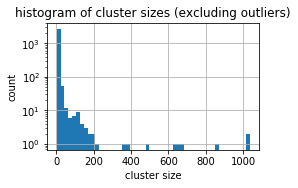

A B 0.09297408904936012
A C 0.09294837138834745
A D 0.09291808590484667
A E 0.09288848701489168
B C 0.09309946433427527
B D 0.09298393979210988
B E 0.09289218546479312
C D 0.0928555428929316
C E 0.09297475148184128
D E 0.09307777952090476
Size of each fold
{'A': 5730, 'B': 5730, 'C': 5730, 'D': 5730, 'E': 5729}
{'A': {'test': 5730, 'train': 17189, 'val': 5730},
 'B': {'test': 5730, 'train': 17189, 'val': 5730},
 'C': {'test': 5730, 'train': 17189, 'val': 5730},
 'D': {'test': 5730, 'train': 17190, 'val': 5729},
 'E': {'test': 5729, 'train': 17190, 'val': 5730}}


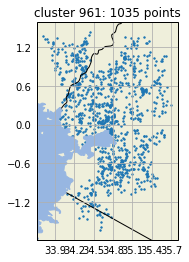

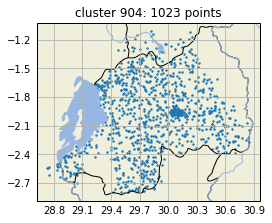

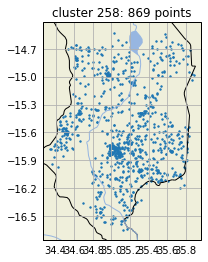

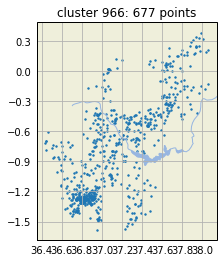

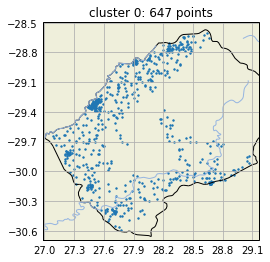

In [132]:
incountry_folds_path = '../data/dhs_incountry_folds.pkl'

create_incountry_folds(locs, incountry_folds_path)
with open(incountry_folds_path, 'rb') as f:
    incountry_folds = pickle.load(f)

pprint({
    f: {split: len(incountry_folds[f][split])
        for split in SPLITS}
    for f in ooc_folds
})